In [28]:
'''
lang:py
author:Yuan
'''
#神奇的sitk库针对mhd文件进行处理，至于raw真想看就用fiji吧。
import numpy as np
import pandas as pd
import SimpleITK as sitk
import os
import matplotlib.pyplot as plt
from skimage import io,data,filters

In [29]:
#简单读取文件,n指的是第几层。
def readfile(img_file,n):
    itk_img = sitk.ReadImage(img_file) 
    img_array = sitk.GetArrayFromImage(itk_img) # indexes are z,y,x (notice the ordering)
    num_z, height, width = img_array.shape        #heightXwidth constitute the transverse plane
    origin = np.array(itk_img.GetOrigin())      # x,y,z  Origin in world coordinates (mm)
    spacing = np.array(itk_img.GetSpacing())    # spacing of voxels in world coor. (mm)
    plt.imshow(img_array[n])#index 500 is out of bounds for axis 0 with size 161经过验证一共161个图堆叠，也就是0-160
    return (img_array[n],plt.cm.gray)#绘制图片,且为灰度图
#readfile('D:PREAI/sample_patients/1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059.mhd',100)
#print img_array[100].shape

In [30]:
#保存某一文件的某一层。
def saveimg(infile,savefile,i,dpi):
    save = readfile(infile,i)
    plt.savefig(savefile+'/test'+'.jpg',format = 'jpg',dpi = dpi,box_inches='tight',facecolor='w')
#saveimg('D:PREAI/sample_patients/1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059.mhd','D:PREAI/Output',100,100)

下面是三种处理图像的方法，但是刚刚跑通，还没有进一步处理。

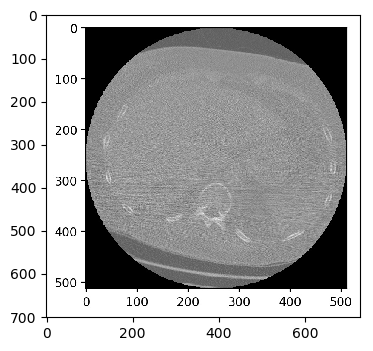

In [31]:
#二值化图像处理
img1 = io.imread('D:PREAI/Output/test1.jpg')  
for value in img1.flat:
    if value >150:
        value = 255
    else:
        value = 0
#img1 = img1.convert('1')
#val = filters.threshold_otsu(camera)
#plt.figure('thresh',dpi = 200)
#plt.subplot(121)
#plt.title('original image')
plt.show(plt.imshow(img1,plt.cm.gray))

In [32]:
#Kmeans图像聚类
from scipy.cluster.vq import *
from scipy.misc import imresize
from pylab import *
from PIL import Image
#steps*steps像素聚类
def clusterpixels_square(infile, k, steps):
    im = array(Image.open(infile))
    #im.shape[0] 高 im.shape[1] 宽
    dx = im.shape[0] / steps
    dy = im.shape[1] / steps
    # 计算每个区域的颜色特征
    features = []
    for x in range(steps):
        for y in range(steps):
            R = mean(im[x * dx:(x + 1) * dx, y * dy:(y + 1) * dy, 0])
            G = mean(im[x * dx:(x + 1) * dx, y * dy:(y + 1) * dy, 1])
            B = mean(im[x * dx:(x + 1) * dx, y * dy:(y + 1) * dy, 2])
            features.append([R, G, B])
    features = array(features, 'f')     # 变为数组
    # 聚类， k是聚类数目
    centroids, variance = kmeans(features, k)
    code, distance = vq(features, centroids)
    # 用聚类标记创建图像
    codeim = code.reshape(steps, steps)
    codeim = imresize(codeim, im.shape[:2], 'nearest')
    return codeim
#stepsX*stepsY像素聚类
def clusterpixels_rectangular(infile, k, stepsX):
    im = array(Image.open(infile))
    stepsY = stepsX * im.shape[1] / im.shape[0]
    #im.shape[0] 高 im.shape[1] 宽
    dx = im.shape[0] / stepsX
    dy = im.shape[1] / stepsY
    # 计算每个区域的颜色特征
    features = []
    for x in range(stepsX):
        for y in range(stepsY):
            R = mean(im[x * dx:(x + 1) * dx, y * dy:(y + 1) * dy, 0])
            G = mean(im[x * dx:(x + 1) * dx, y * dy:(y + 1) * dy, 1])
            B = mean(im[x * dx:(x + 1) * dx, y * dy:(y + 1) * dy, 2])
            features.append([R, G, B])
    features = array(features, 'f')     # 变为数组
    # 聚类， k是聚类数目
    centroids, variance = kmeans(features, k)
    code, distance = vq(features, centroids)
      # 用聚类标记创建图像
    codeim = code.reshape(stepsX, stepsY)
    codeim = imresize(codeim, im.shape[:2], 'nearest')
    return codeim
#计算最优steps 为保证速度以及减少噪点 最大值为maxsteps 其值为最接近且小于maxsteps 的x边长的约数
def getfirststeps(img,maxsteps):
    msteps = img.shape[0]
    n = 2
    while(msteps>maxsteps):
        msteps =   img.shape[0]/n
        n = n + 1    
    return msteps

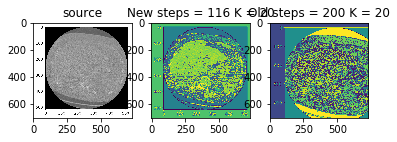

In [33]:
#要先保存为图像文件然后进行操作
infile='D:PREAI/Output/test1.jpg'
im = array(Image.open(infile))
#参数
m_k = 20
m_maxsteps = 128
#显示原图empire.jpg
figure()
subplot(131)
title('source')
imshow(im)
# 用改良矩形块对图片的像素进行聚类
codeim= clusterpixels_rectangular(infile, m_k,getfirststeps(im,m_maxsteps))
subplot(132)
title('New steps = '+str(getfirststeps(im,m_maxsteps))+' K = '+str(m_k));
imshow(codeim)
#方形块对图片的像素进行聚类
codeim= clusterpixels_square(infile, 15, 200)
subplot(133)
title('Old steps = 200 K = '+str(m_k));
imshow(codeim)
show()

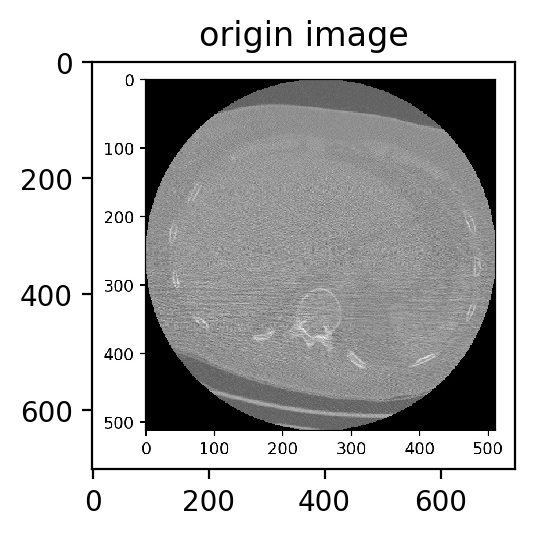

In [35]:
#滤波器过滤图像
from skimage.morphology import disk
import skimage.filters.rank as sfr
from skimage import color
img1 = imread('D:PREAI/Output/test1.jpg')  
img =color.rgb2gray(img1)
#auto =sfr.autolevel(img, disk(5))
#dst =sfr.mean(img, disk(5)) 
dst =sfr.minimum(img, disk(30))
plt.figure('filters',dpi = 200)
plt.subplot(121)
plt.title('origin image')
plt.show(plt.imshow(img,plt.cm.gray))